## National Transportation Safety Board Accident/Incident Data

Author: Kirsty Weitzel

This notebook explores the xml data provided by the NTSB. 

- Data Ingestion
- Data Cleaning
- Initial Exploration & Plotting

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET  #XML parsing (https://docs.python.org/2/library/xml.etree.elementtree.html)
import numpy as np
import re #regex
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

### Data Ingestion

In [117]:
#Prase XML data using ElementTree 
xmltree = ET.parse('data/AviationData.xml')

#Create blank list
data = []

#Iterate through xml tree - return all attributes(*)
for el in xmltree.iterfind('*'):
    for i in el.iterfind('*'):
        #Append dictionary of data to list
        data.append(dict(i.items()))

#Convert list to dataframe
df = pd.DataFrame(data)
df.head()

,EventId,InvestigationType,AccidentNumber,EventDate,Location,Country,Latitude,Longitude,AirportCode,AirportName,InjurySeverity,AircraftDamage,AircraftCategory,RegistrationNumber,Make,Model,AmateurBuilt,NumberOfEngines,EngineType,FARDescription,Schedule,PurposeOfFlight,AirCarrier,TotalFatalInjuries,TotalSeriousInjuries,TotalMinorInjuries,TotalUninjured,WeatherCondition,BroadPhaseOfFlight,ReportStatus,PublicationDate
0,20150901X74304,Accident,GAA15CA244,09/01/2015,"Truckee, CA",United States,,,,,,,,N786AB,JOE SALOMONE,SUPER CUB SQ2,,,,,,,,,,,,,,Preliminary,
1,20150901X92332,Accident,CEN15LA392,08/31/2015,"Houston, TX",United States,29.809444,-95.668889,IWS,WEST HOUSTON,Non-Fatal,Substantial,Airplane,N452CS,CESSNA,T240,No,,,Part 91: General Aviation,,Instructional,,,,,2,VMC,LANDING,Preliminary,09/04/2015
2,20150902X61853,Accident,GAA15CA246,08/30/2015,"New Milford, CT",United States,,,,,,,,N112RP,CESSNA,170A,,,,,,,,,,,,,,Preliminary,
3,20150901X02521,Accident,GAA15CA243,08/30/2015,"New Enterprise, PA",United States,,,,,,,,N8404X,CESSNA,172C,,,,,,,,,,,,,,Preliminary,
4,20150831X61356,Accident,GAA15CA242,08/29/2015,"MIDLOTHIAN, TX",United States,,,,,,,,N5255G,CESSNA,305A,,,,,,,,,,,,,,Preliminary,


In [115]:
df.shape

(77257, 31)

### Data Cleaning

The function below takes in the dataframe and returns a cleaned version of it:

- Subset to data of interest
    - The years 1982-2014 have complete data
    - Subset to incidents/accdients in the US
- Ensuring missing values are represented as `np.nan`, instead of blank strings
- Creating date features (`month`, `year`)
- Split `Location` field into `City`, `State`
- Case normalization of strings
    - Example: 'anchorage' should be the same as 'ANCHORAGE'
- Cleaning the problematic `AirCarrier` field, which had many representations of the same value
    - Example: "DELTA AIR LINES INC", "DELTA AIRLINES", "DELTA AIR LINES", "DBA Delta Airlines"

In [104]:
def clean_xml_data(df):
    
    #Create date field
    df['EventDate'] = pd.to_datetime(df['EventDate'])
    
    #Subset to US fatalities, since that is the primary interest of the NTSB data
    #Subset data to after 1981, since there are only 4 records prior
    mask = (df['Country'] == 'United States') & (df['EventDate'] >= '1982-01-01') & (df['EventDate'] < '2015-01-01')
    df_subset = df.loc[mask]
    
    #Replace blank values with NaN
    df_copy = df_subset.replace('', np.nan).replace(r'\s*', np.nan)
    
    #Split States/Cities in Location Field
    df_copy['City'] = df_subset.Location.str.title().str.split(', ', expand=True)[0]
    df_copy['State'] = df_subset.Location.str.upper().str.split(', ', expand=True)[1]
    
    #Strip Number from Injury Serverity Field
    df_copy['InjurySeverity'] = df_subset['InjurySeverity'].str.replace('(?<=Fatal).*','')
    
    #Extract variables from date field
    df_copy['year'] = pd.DatetimeIndex(df_subset['EventDate']).year
    df_copy['month'] = pd.DatetimeIndex(df_subset['EventDate']).month

    #Cast numerical fields to float64
    num_cols = ['Latitude', 'Longitude', 'TotalFatalInjuries', 'TotalMinorInjuries', 'TotalSeriousInjuries', 'TotalUninjured',
               'NumberOfEngines']
    df_copy[num_cols] = df_copy[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)
    
    #Case normalization of strings
    df_copy = df_copy.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
    
    #Clean AirCarrier Names
    df_copy['AirCarrier'] = df_copy.AirCarrier.str.replace('inc', '').str.replace(r'[^\w\s]','').str.replace('air lines','airlines').str.replace(r'^dba\s', '').str.replace(r'.+?(?=dba)dba\s', '')
    df_copy['AirCarrier'] = df_copy['AirCarrier'].str.strip()
    
    return(df_copy)
    
df_clean = clean_xml_data(df)
df_clean.head()

,EventId,InvestigationType,AccidentNumber,EventDate,Location,Country,Latitude,Longitude,AirportCode,AirportName,InjurySeverity,AircraftDamage,AircraftCategory,RegistrationNumber,Make,Model,AmateurBuilt,NumberOfEngines,EngineType,FARDescription,Schedule,PurposeOfFlight,AirCarrier,TotalFatalInjuries,TotalSeriousInjuries,TotalMinorInjuries,TotalUninjured,WeatherCondition,BroadPhaseOfFlight,ReportStatus,PublicationDate,City,State,year,month
986,20141231x83422,accident,wpr15ta071,2014-12-31,"las vegas, nv",united states,NaN,NaN,kvgt,north las vegas,non-fatal,substantial,helicopter,n530kk,md helicopter inc,369ff,no,NaN,turbo shaft,part 91: general aviation,NaN,public aircraft - local,NaN,NaN,NaN,2.0,NaN,NaN,NaN,preliminary,01/07/2015,las vegas,nv,2014,12
987,20150101x15630,accident,wpr15fa072,2014-12-31,"benson, az",united states,31.956111,-110.409444,NaN,n/a,fatal,destroyed,helicopter,n57aw,bell,206,no,1.0,turbo shaft,part 91: general aviation,NaN,positioning,NaN,2.0,NaN,NaN,NaN,unk,NaN,preliminary,01/07/2015,benson,az,2014,12
988,20141231x81005,accident,era15la087,2014-12-30,"fort pierce, fl",united states,27.497222,-80.372500,fpr,st lucie county intl,non-fatal,substantial,airplane,n419pe,mds fying llc,zenith zodiac ch 650,yes,1.0,reciprocating,part 91: general aviation,NaN,personal,NaN,NaN,NaN,NaN,1.0,vmc,NaN,preliminary,01/12/2015,fort pierce,fl,2014,12
989,20141231x01659,accident,cen15la091,2014-12-30,"roswell, nm",united states,33.287222,-104.539166,row,roswell intl air center,non-fatal,substantial,airplane,n950fe,cessna,208b,no,2.0,turbo prop,part 135: air taxi & commuter,schd,NaN,baron aviation services,NaN,NaN,NaN,1.0,imc,NaN,preliminary,01/05/2015,roswell,nm,2014,12
990,20150101x13628,accident,cen15fa092,2014-12-30,"vaughn, nm",united states,34.466389,-105.297222,NaN,n/a,fatal,substantial,airplane,n2558m,piper,pa 28-181,no,1.0,reciprocating,part 91: general aviation,NaN,personal,NaN,2.0,NaN,NaN,NaN,imc,descent,factual,08/25/2015,vaughn,nm,2014,12


In [66]:
df_clean.to_csv('data/aviation_data.csv')

In [100]:
print('There are {} incidents/accidents in the data, with {} columns.\nThe columns available are:\n{}'.format(df_clean.shape[0], df_clean.shape[1], df_clean.columns.to_list()))

There are 72198 incidents/accidents in the data, with 35 columns.
The columns available are:
['EventId', 'InvestigationType', 'AccidentNumber', 'EventDate', 'Location', 'Country', 'Latitude', 'Longitude', 'AirportCode', 'AirportName', 'InjurySeverity', 'AircraftDamage', 'AircraftCategory', 'RegistrationNumber', 'Make', 'Model', 'AmateurBuilt', 'NumberOfEngines', 'EngineType', 'FARDescription', 'Schedule', 'PurposeOfFlight', 'AirCarrier', 'TotalFatalInjuries', 'TotalSeriousInjuries', 'TotalMinorInjuries', 'TotalUninjured', 'WeatherCondition', 'BroadPhaseOfFlight', 'ReportStatus', 'PublicationDate', 'City', 'State', 'year', 'month']


In [111]:
#Comparison of original and cleaned AirCarrier columns
print('Original Column: \n', df.AirCarrier.value_counts()[:20])
print('\nCleaned Column:\n',df_clean.AirCarrier.value_counts()[:20])

Original Column: 
                                           73439
UNITED AIRLINES                              49
AMERICAN AIRLINES                            41
CONTINENTAL AIRLINES                         25
USAIR                                        24
DELTA AIR LINES INC                          23
AMERICAN AIRLINES, INC.                      22
SOUTHWEST AIRLINES CO                        21
CONTINENTAL AIRLINES, INC.                   19
UNITED AIR LINES INC                         14
SIMMONS AIRLINES (DBA: AMERICAN EAGLE)       12
AMERICAN AIRLINES INC                        12
US AIRWAYS INC                               12
DELTA AIRLINES                               11
TRANS WORLD AIRLINES                         11
United Airlines                              11
(DBA: UNITED EXPRESS)                        10
(DBA: [EMS])                                 10
DELTA AIR LINES                              10
NORTHWEST AIRLINES                           10
Name: AirCarrier, dty

In [68]:
#Count missing values 
df_clean.isna().sum()

EventId                     0
InvestigationType           0
AccidentNumber              0
EventDate                   0
Location                   31
Country                     0
Latitude                50342
Longitude               50352
AirportCode             29900
AirportName             26476
InjurySeverity              0
AircraftDamage           1750
AircraftCategory        58105
RegistrationNumber        144
Make                       23
Model                      40
AmateurBuilt              159
NumberOfEngines          1290
EngineType                963
FARDescription          57952
Schedule                62769
PurposeOfFlight          1868
AirCarrier              68568
TotalFatalInjuries      19227
TotalSeriousInjuries    20281
TotalMinorInjuries      19173
TotalUninjured           8977
WeatherCondition          240
BroadPhaseOfFlight       2620
ReportStatus                0
PublicationDate         12365
City                        0
State                      31
year      

## Data Exploration

In [90]:
#Summary of numeric columns:
df_clean.describe()

,Latitude,Longitude,NumberOfEngines,TotalFatalInjuries,TotalSeriousInjuries,TotalMinorInjuries,TotalUninjured,year,month
count,21856.000000,21846.000000,70908.000000,52971.000000,51917.000000,53025.000000,63221.000000,72198.000000,72198.000000
mean,38.999751,-98.328717,1.140393,0.517302,0.273494,0.437624,4.744246,1995.610169,6.580944
std,8.532089,30.698978,0.446614,2.801719,0.936332,1.661868,25.367954,9.501655,3.042843
min,-61.883334,-193.216667,0.000000,0.000000,0.000000,0.000000,0.000000,1982.000000,1.000000
25%,33.688333,-116.101111,1.000000,0.000000,0.000000,0.000000,0.000000,1987.000000,4.000000
50%,38.365556,-95.809028,1.000000,0.000000,0.000000,0.000000,1.000000,1995.000000,7.000000
75%,42.531598,-82.681458,1.000000,1.000000,0.000000,1.000000,2.000000,2003.000000,9.000000
max,87.145833,174.333333,24.000000,265.000000,81.000000,137.000000,699.000000,2014.000000,12.000000


Plot counts of top 20 values in non-numeric columns, to unerstand which values are most common in the data

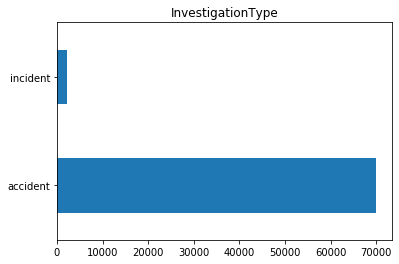

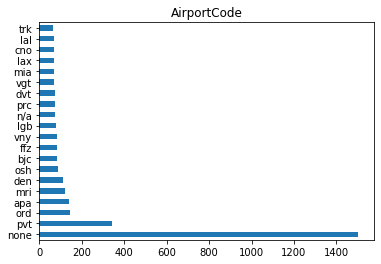

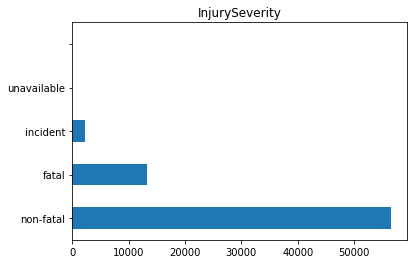

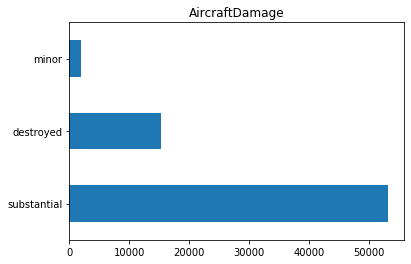

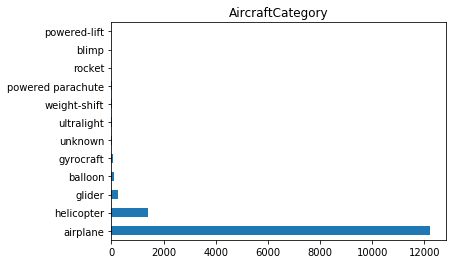

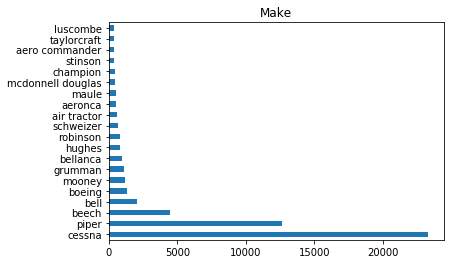

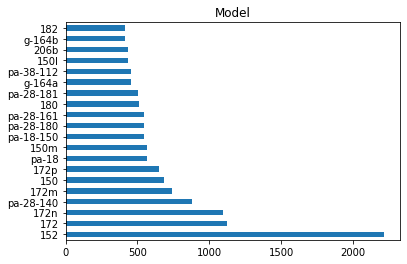

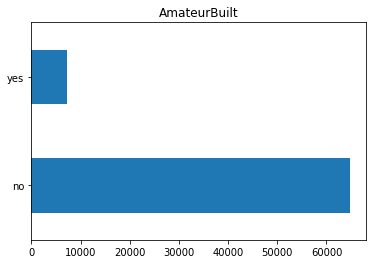

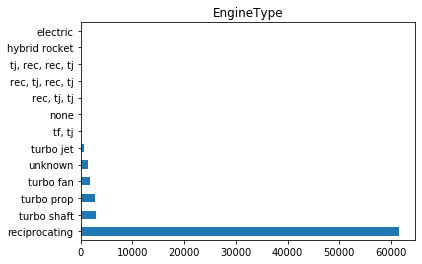

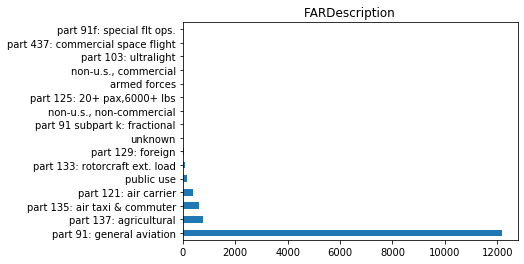

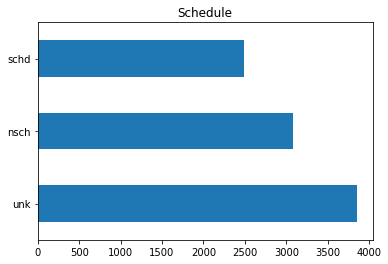

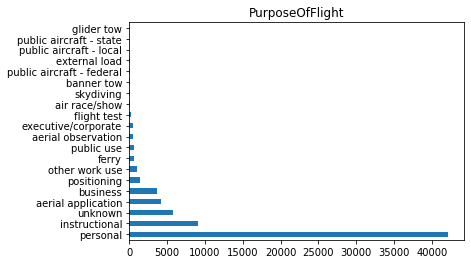

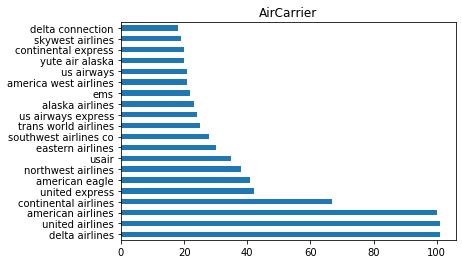

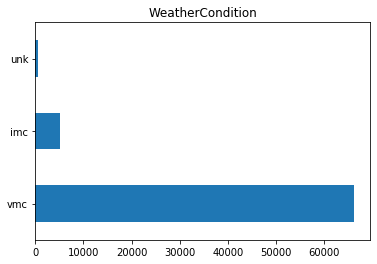

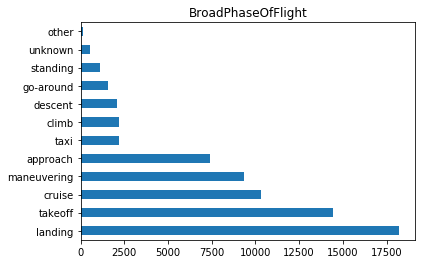

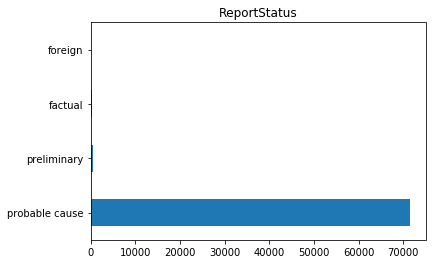

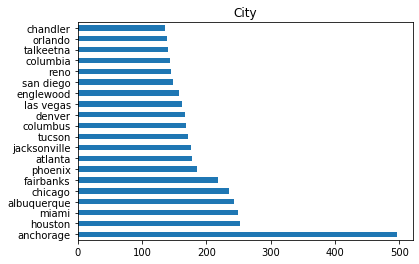

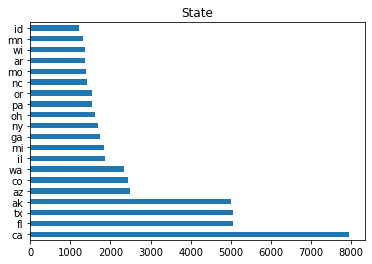

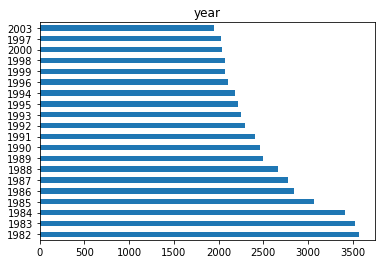

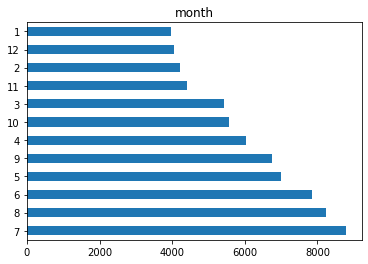

In [71]:
#Create list of columns to plot
plot_cols = ['InvestigationType', 'AirportCode', 'InjurySeverity', 'AircraftDamage', 'AircraftCategory', 'Make', 
            'Model', 'AmateurBuilt', 'EngineType', 'FARDescription', 'Schedule', 'PurposeOfFlight', 'AirCarrier', 
             'WeatherCondition', 'BroadPhaseOfFlight', 'ReportStatus', 'City', 'State', 'year', 'month']

#For each column, create horizontal bar chart of most common values (up to 20 unique values)
for col in plot_cols:
    
    df_clean[col].value_counts()[:20].plot(kind='barh')
    plt.title(col)
    plt.show()

Looking at these plots, it's interesting that 

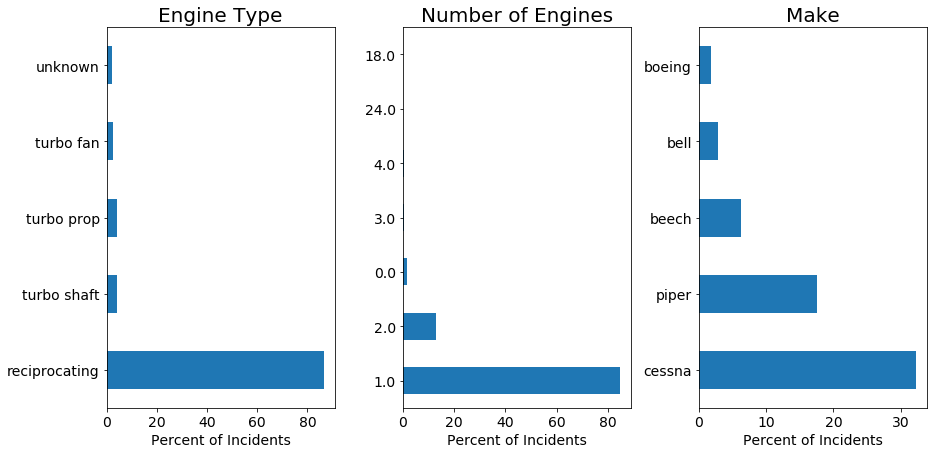

In [75]:
fig, ax = plt.subplots(figsize=(20, 7), sharex=True)

plt.subplot(1, 3, 1)
enginetype = df_clean['EngineType'].value_counts(normalize=True)[:5] * 100
enginetype.plot(kind='barh')
plt.xlabel('Percent of Incidents', fontsize=14)
plt.title('Engine Type' ,fontsize=20)
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 2)
engineno = df_clean['NumberOfEngines'].value_counts(normalize=True) * 100
engineno.plot(kind='barh')
plt.xlabel('Percent of Incidents',fontsize=14)
plt.title('Number of Engines',fontsize=20)
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 3)
make = df_clean['Make'].value_counts(normalize=True)[:5] * 100
make.plot(kind='barh')
plt.xlabel('Percent of Incidents',fontsize=14)
plt.title('Make',fontsize=20)
plt.tick_params(labelsize=14)

#Adjust whitespace between plots so the labels don't overlap
plt.subplots_adjust(wspace=.3)

Is the distribution of small craft similar when subsetting to fatal incidents?

From plots, looks very similar in fatal incidents vs. all incidents

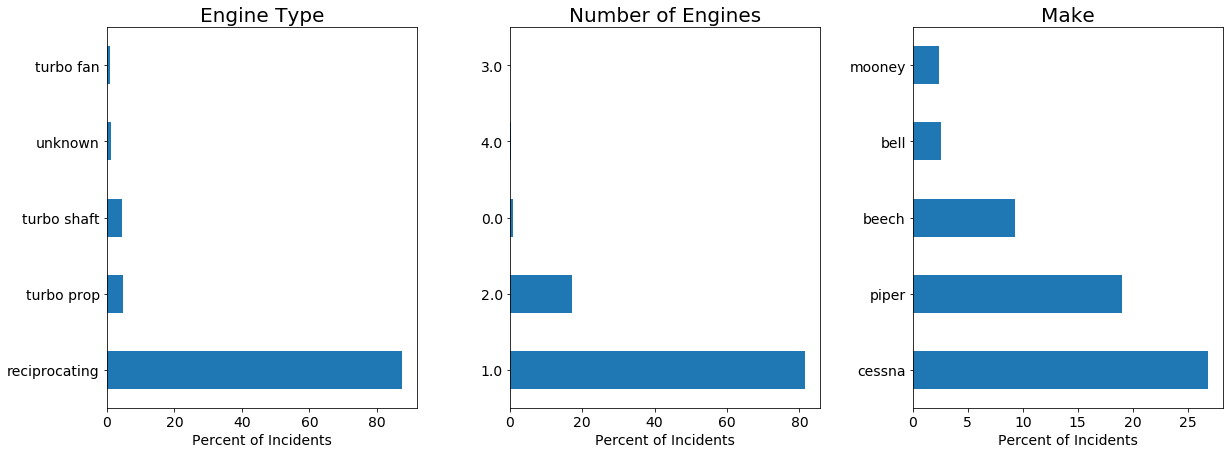

In [96]:
fig, ax = plt.subplots(figsize=(20, 7), sharex=True)

#Create dataframe of only fatal accidents
fatal = df_clean[df_clean['TotalFatalInjuries'] >= 1]

plt.subplot(1, 3, 1)
enginetype_fatal = fatal['EngineType'].value_counts(normalize=True)[:5] * 100
enginetype_fatal.plot(kind='barh')
plt.xlabel('Percent of Incidents', fontsize=14)
plt.title('Engine Type' ,fontsize=20)
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 2)
engineno_fatal = fatal['NumberOfEngines'].value_counts(normalize=True) * 100
engineno_fatal.plot(kind='barh')
plt.xlabel('Percent of Incidents',fontsize=14)
plt.title('Number of Engines',fontsize=20)
plt.tick_params(labelsize=14)

plt.subplot(1, 3, 3)
make_fatal = fatal['Make'].value_counts(normalize=True)[:5] * 100
make_fatal.plot(kind='barh')
plt.xlabel('Percent of Incidents',fontsize=14)
plt.title('Make',fontsize=20)
plt.tick_params(labelsize=14)

#Adjust whitespace between plots so the labels don't overlap
plt.subplots_adjust(wspace=.3)

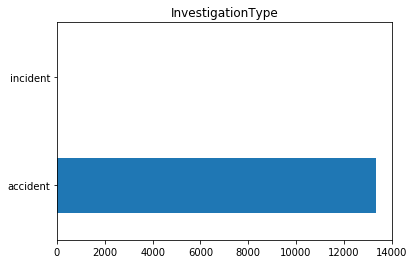

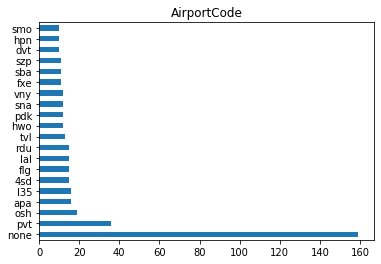

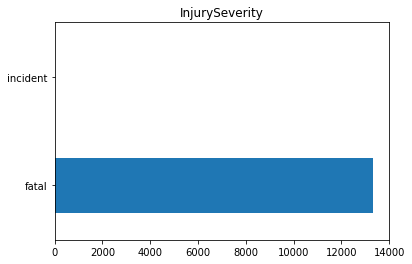

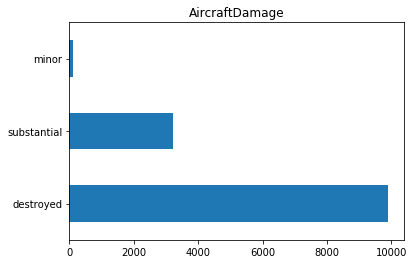

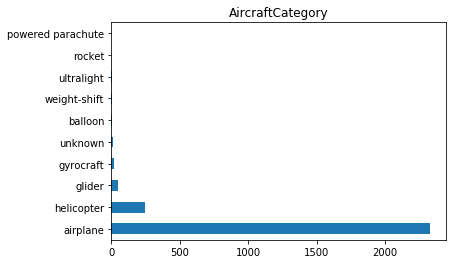

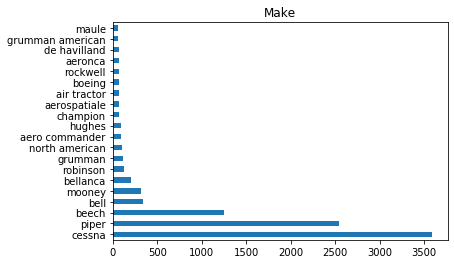

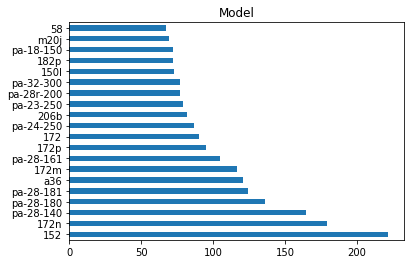

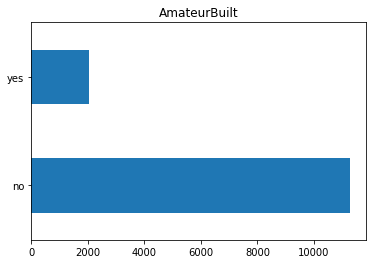

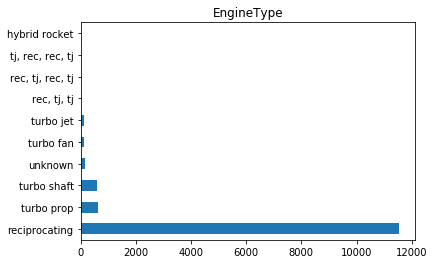

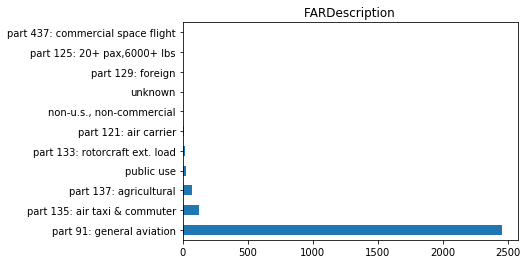

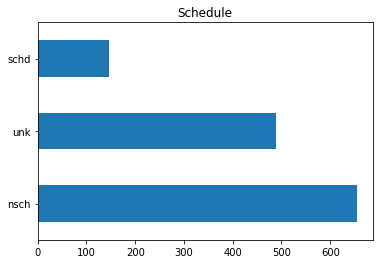

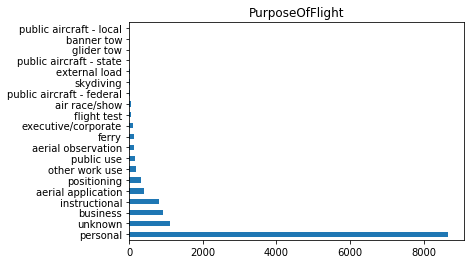

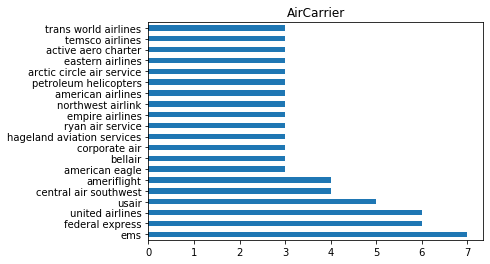

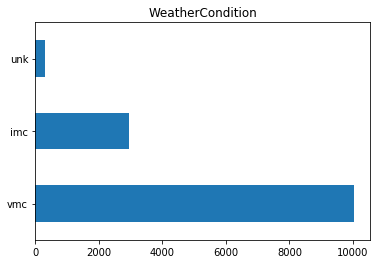

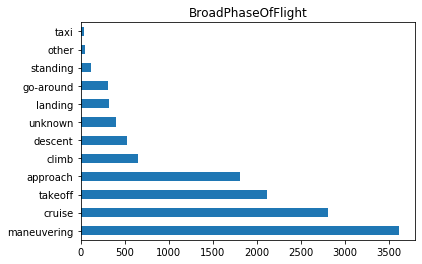

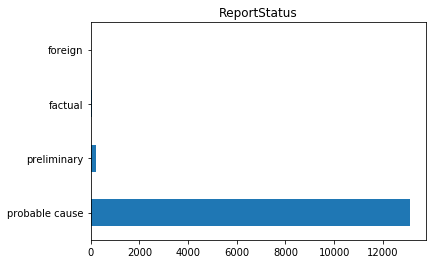

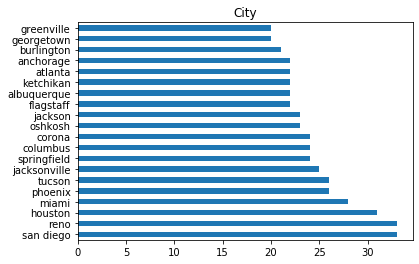

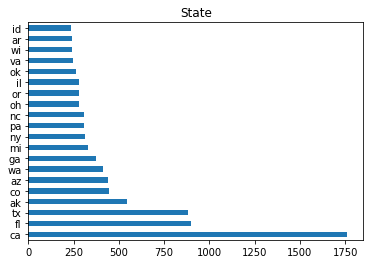

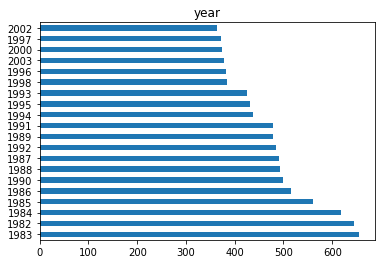

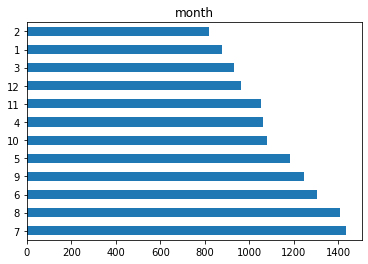

In [98]:
plot_cols = ['InvestigationType', 'AirportCode', 'InjurySeverity', 'AircraftDamage', 'AircraftCategory', 'Make', 
            'Model', 'AmateurBuilt', 'EngineType', 'FARDescription', 'Schedule', 'PurposeOfFlight', 'AirCarrier', 
             'WeatherCondition', 'BroadPhaseOfFlight', 'ReportStatus', 'City', 'State', 'year', 'month']

for col in plot_cols:
    
    fatal[col].value_counts()[:20].plot(kind='barh')
    plt.title(col)
    plt.show()

In [121]:
fatal.shape

(13354, 36)

In [84]:
df_clean['Target']

986      0
987      1
988      0
989      0
990      1
        ..
77243    0
77244    0
77245    0
77246    0
77247    0
Name: Target, Length: 72198, dtype: int64

In [81]:
df_clean.dtypes

EventId                         object
InvestigationType               object
AccidentNumber                  object
EventDate               datetime64[ns]
Location                        object
Country                         object
Latitude                       float64
Longitude                      float64
AirportCode                     object
AirportName                     object
InjurySeverity                  object
AircraftDamage                  object
AircraftCategory                object
RegistrationNumber              object
Make                            object
Model                           object
AmateurBuilt                    object
NumberOfEngines                float64
EngineType                      object
FARDescription                  object
Schedule                        object
PurposeOfFlight                 object
AirCarrier                      object
TotalFatalInjuries             float64
TotalSeriousInjuries           float64
TotalMinorInjuries       

In [76]:
engineno

1.0     84.690021
2.0     12.833531
0.0      1.418740
3.0      0.596548
4.0      0.458340
24.0     0.001410
18.0     0.001410
Name: NumberOfEngines, dtype: float64

In [79]:
df_clean['TotalFatalInjuries']

986      NaN
987      2.0
988      NaN
989      NaN
990      2.0
        ... 
77243    0.0
77244    0.0
77245    0.0
77246    0.0
77247    0.0
Name: TotalFatalInjuries, Length: 72198, dtype: float64

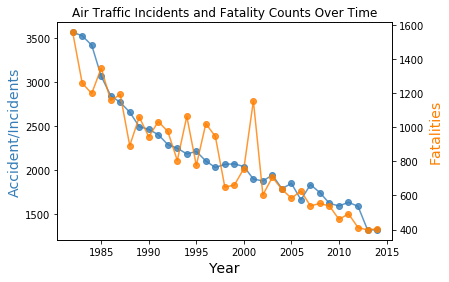

In [73]:
#Plot number of incidents and fatalities over time

#Count incidents and fatalities by year
yearly_incidents = df_clean.groupby('year').agg({'count'}).EventId.reset_index()
yearly_fatalities = df_clean.groupby('year').agg({'sum'}).TotalFatalInjuries.reset_index()

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# Plot Yearly Incidents
ax.plot(yearly_incidents['year'], yearly_incidents['count'], color='#377eb8', marker="o", alpha = .8)

# Set axis labels
ax.set_xlabel("Year",fontsize=14)
ax.set_ylabel("Accident/Incidents",color='#377eb8',fontsize=14)

# Plot Yearly Fatalities on second axis
ax2=ax.twinx()
ax2.plot(yearly_fatalities['year'], yearly_fatalities['sum'],color='#ff7f00',marker="o", alpha = .8)
ax2.set_ylabel("Fatalities",color='#ff7f00',fontsize=14)
plt.title('Air Traffic Incidents and Fatality Counts Over Time')
plt.show()

In [62]:
#Counts of number of engines by EngineType
df_clean.groupby(['EngineType', 'NumberOfEngines']).agg({'count'}).EventId

count
EngineType       NumberOfEngines       
electric         1.0                  1
hybrid rocket    1.0                  1
none             0.0                  3
rec, tj, rec, tj 4.0                  1
rec, tj, tj      4.0                  2
reciprocating    1.0              56087
                 2.0               5333
                 3.0                  5
                 4.0                 48
                 18.0                 1
                 24.0                 1
tf, tj           2.0                  3
tj, rec, rec, tj 4.0                  1
turbo fan        1.0                 24
                 2.0               1303
                 3.0                319
                 4.0                194
turbo jet        1.0                 82
                 2.0                413
                 3.0                 95
                 4.0                 38
turbo prop       1.0               1134
                 2.0               1579
                 4.0                 33
turbo shaft      1.0               2528
                 2.0                400
                 3.0                  1
unknown          0.0                563
                 1.0                 71
                 2.0                 12
                 3.0                  1
                 4.0                  1